<a href="https://colab.research.google.com/github/ndallen77/colab-test/blob/master/Ocean_Wind_Glider_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi!  This is a demo tool for ***extracting HYCOM/NCOM forecasts, winds, and glider data*** and plotting it like so:

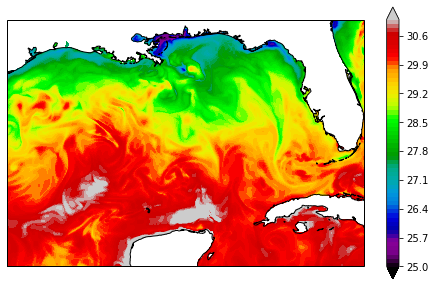


If you are new to Jupyter Notebooks and/or Google Colab, then you're probably seeing "Warning: This notebook was not authored by Google."

That is true -- I am not Nathan "Google" Allen.  Please take a moment to review the code before accepting "Run Anyway" or, as an alternative to trusting the code, this notebook is setup to allow you to save a local copy on your own Google Drive.

See the current access list of personnel who are currently granted access to this folder for adding data.

.

The program fetches data from NOAA's ERDDAP/THREDDS servers to access model
data (HYCOM/NCOM for ocean, GFS/NAVGEM for atmo) and also glider data, and
plots Navy glider tracks in blue, and NOAA gliders in a different color.
 
 .

Anyway, to start running the Notebook, just click into a cell, hit [SHIFT][ENTER] on your keyboard to run the first cell and auto-advance to the next cell... keep hitting [SHIFT][ENTER] until you've gotten to a pretty picture!

Hint: it can take 15-20 seconds to load cartopy + dependencies the first time after that, it should stay remain loaded in your browser's memory (and should only take less than 60 mb browser RAM... very light...)

Data you download can reside as up to ~750 MB in your browser's RAM, and over 60 GB in temporary storage on Google's servers while running code.


# And... now for some code!
#### Individual sections start off collapsed, but can be opened for inspection by double-clicking on the code.  The output will display as it is executed.
#### Just keep hitting [SHIFT][ENTER] after each code block finishes executing.

In [ ]:
#@title Install modules
!apt-get install -qq libgdal-dev 
!apt-get install -qq libproj-dev
!apt-get install -qq proj-data 
!apt-get install -qq proj-bin
!apt-get install -qq libgeos-dev
!apt install python3-dev

!pip install cartopy==0.17.0
# Hint: it can take 15-20 seconds to load cartopy + dependencies the first time
#       after that, it should stay remain loaded in your browser's memory (and
#       should only take <60 mb browser RAM... very light)

In [ ]:
#@title Import modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker
import matplotlib.animation as animation
    
import numpy as np

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

import pandas as pd
import urllib3
#!pip show matplotlib
#!pip show cartopy

%matplotlib inline


In [ ]:
#@title Modules used to fetch data from ERDDAP/THREDDS sources.  Inspect this code if you run into problems during data downloads.
# Obtains ocean model and displays output
def model_df(model_url, dataTypeString):
    from pandas import DataFrame, read_csv
    url = ('https://www.ncei.noaa.gov/erddap/griddap/' + 
           model_url + '.csv?' + dataTypeString)
    print(url)
    try:
        df = read_csv(url, index_col='time', parse_dates=True, skiprows=[1])
    except:
        df = pd.DataFrame()
    return df

# Obtains wind model and displays output; need to find better winds
def windModel_df(model_urlW, dataTypeStringW):
    from pandas import DataFrame, read_csv
    urlW = ('https://coastwatch.pfeg.noaa.gov/erddap/griddap/' + 
           model_urlW + '.csv?' + dataTypeStringW)
    print(urlW)
    try:
        dfW = read_csv(urlW, index_col='time', parse_dates=True, skiprows=[1])
    except:
        dfW = pd.DataFrame()
    return dfW

# Pulls glider data from NOAA ERDDAP
def download_dfG(glider_id):
    from pandas import DataFrame, read_csv
#    from urllib.error import HTTPError
    uri = ('https://data.ioos.us/gliders/erddap/tabledap/{}.csv'
           '?trajectory,wmo_id,time,latitude,longitude'
#           '?trajectory,wmo_id,time,latitude,longitude,depth,pressure,temperature,salinity'
           '&time%3E={}'
           '&time%3C={}'
           '&latitude%3E={}'
           '&latitude%3C={}'
           '&longitude%3E={}'
           '&longitude%3C={}').format
#           '&temperature!=NaN').format
    url = uri(glider_id,startG,stopG,latMin,latMax,lonMin-360,lonMax-360) #.encode('utf-8')
    print(url)

    # Not sure if returning an empty df is the best idea.
    try:
        dfG = read_csv(url, index_col='time', parse_dates=True, skiprows=[1])
    except:
        dfG = pd.DataFrame()
    return dfG

In [ ]:
#@title Sets date ranges to search for glider data & model data, as well as location.  Can be modified by anyone running the Jupyter Notebook.
# Glider time range for display tracks
startG = '2020-10-23T06:00:00Z'
stopG  = '2020-10-28T18:00:00Z'

# Time range for models to use, currenly set to be the same to display only
# one model time interval (another program gather multiple taus... needs
# more development)
#start = stop = '2020-10-27T18:00:00Z'
start = stop = stopG
#stop  = '2020-10-23T12:00:00Z'

# Range to seek for available gliders, ocean & wind models
latMin =  18 #15
latMax =  30.5
lonMin = -98
lonMax = -81 #-74

# For this module, only searches for a single depth, but can be set to any
# available depth for HYCOM/NCOM levels
minDepth = maxDepth = 0

# Only looking at water temp, but can include other variables (at expense
# of slower download times -- negligible for single taus/depths, though
standardName = ['water_temp']
#standardName = ['water_temp','salinity']
#standardName = ['water_temp','water_v','water_u','salinity']

# Most search strings require conversion to/from uLons & Lons (i.e., 0-360 vs
# -180 through + 180, respectively).  Most is handled properly at this point.
lonMin = lonMin + 360
lonMax = lonMax + 360

In [ ]:
#@title Code/search strings for seeking glider data (no interaction needed, no output)
# Glider search string for ERDDAP/THREDDS pull
base = (
    'https://data.ioos.us/gliders/erddap/search/advanced.csv'
    '?page=1'
    '&itemsPerPage=1000'
    '&searchFor='
    '&protocol=(ANY)'
    '&cdm_data_type=(ANY)'
#    '&institution=naval_oceanographic_office'#(ANY)'
    '&institution=(ANY)'
    '&ioos_category=(ANY)'
    '&keywords=(ANY)'
    '&long_name=(ANY)'
    '&standard_name={}'
    '&variableName=(ANY)'
    '&maxLat={}'
    '&minLon={}'
    '&maxLon={}'
    '&minLat={}'
    '&minTime={}'
    '&maxTime={}'
    '&depth%3E=45&depth%3C=50').format

url = base(
    'salinity',
    latMax,
    lonMin-360,
    lonMax-360,
    latMin,
    startG,
    stopG
)

#print(url)
dfGt = pd.read_csv(url, usecols=['Title', 'Summary', 'Institution'])  



In [ ]:
#@title Displays links for glider data (no interaction needed, just lets you know it worked)
# Searches for possible glider datasets, displays link (in case you experience
# errors, you can click on the link to see what went wrong) and displays an
# example of the pandas dataframe/series

dfGs = list(map(download_dfG, dfGt['Title'].values))
dfG = pd.concat(dfGs)
print('Total Data Values Found: {}'.format(len(dfG)))
dfG.head()


https://data.ioos.us/gliders/erddap/tabledap/ng314-20200806T2040.csv?trajectory,wmo_id,time,latitude,longitude&time%3E=2020-10-23T06:00:00Z&time%3C=2020-10-28T18:00:00Z&latitude%3E=18&latitude%3C=30.5&longitude%3E=-98&longitude%3C=-81
https://data.ioos.us/gliders/erddap/tabledap/SG601-20200906T1631.csv?trajectory,wmo_id,time,latitude,longitude&time%3E=2020-10-23T06:00:00Z&time%3C=2020-10-28T18:00:00Z&latitude%3E=18&latitude%3C=30.5&longitude%3E=-98&longitude%3C=-81
https://data.ioos.us/gliders/erddap/tabledap/stella-20201014T0000.csv?trajectory,wmo_id,time,latitude,longitude&time%3E=2020-10-23T06:00:00Z&time%3C=2020-10-28T18:00:00Z&latitude%3E=18&latitude%3C=30.5&longitude%3E=-98&longitude%3C=-81
https://data.ioos.us/gliders/erddap/tabledap/Stommel-20200813T1200.csv?trajectory,wmo_id,time,latitude,longitude&time%3E=2020-10-23T06:00:00Z&time%3C=2020-10-28T18:00:00Z&latitude%3E=18&latitude%3C=30.5&longitude%3E=-98&longitude%3C=-81
Total Data Values Found: 694


,trajectory,wmo_id,latitude,longitude
time,,,,
2020-10-23 06:55:52+00:00,ng314-20200806T2040,4802980,27.271828,-93.379196
2020-10-23 07:44:06+00:00,ng314-20200806T2040,4802980,27.275900,-93.372398
2020-10-23 08:49:12+00:00,ng314-20200806T2040,4802980,27.266186,-93.381035
2020-10-23 09:37:04+00:00,ng314-20200806T2040,4802980,27.269899,-93.374855
2020-10-23 10:42:01+00:00,ng314-20200806T2040,4802980,27.260757,-93.384949


In [ ]:
#@title Groups glider data (no interaction needed)
# the regrouping has to be done in a separate cell at the moment... not
# sure what I'm doing wrong, but this works... will fix later

dfG.tail()
g = dfG.groupby('trajectory')

In [ ]:
#@title Code/search strings for seeking ocean models (no interaction needed); will display successful search string upon completion.
# Easy html string to extract ocean model from ERDDAP/THREDDS
# note that you can go to NCEI NOAA site to determine actual
# model name for proper search... only looking for NCOM (amseas
# and useast) at the moment, but easy to expand to HYCOM, 
# NCOM for alaska and socal, RTOFS.  
# Need to figure out how to access European ERDDAP for display.

varString = ''
for mVar in standardName:
  varString = (varString +',' + mVar +
               '[(' + str(start) + '):1:(' + str(stop) + ')]' +
               '[(' + str(minDepth) + '):1:(' + str(maxDepth) + ')]' +
               '[(' + str(latMin) + '):1:(' + str(latMax) + ')]' +
               '[(' + str(lonMin) + '):1:(' + str(lonMax) + ')]')
  
varString = varString[1:500]
print(varString)

#df = model_df('NCOM_amseas_latest3d', varString)
#df = model_df('NCOM_us_east_latest3d', varString)
df = model_df('HYCOM_reg1_latest3d', varString)
df.head()


water_temp[(2020-10-28T18:00:00Z):1:(2020-10-28T18:00:00Z)][(0):1:(0)][(18):1:(30.5)][(262):1:(279)]
https://www.ncei.noaa.gov/erddap/griddap/HYCOM_reg1_latest3d.csv?water_temp[(2020-10-28T18:00:00Z):1:(2020-10-28T18:00:00Z)][(0):1:(0)][(18):1:(30.5)][(262):1:(279)]


,depth,latitude,longitude,water_temp
time,,,,
2020-10-28 18:00:00+00:00,0.0,18.0,262.000031,NaN
2020-10-28 18:00:00+00:00,0.0,18.0,262.080048,NaN
2020-10-28 18:00:00+00:00,0.0,18.0,262.160034,NaN
2020-10-28 18:00:00+00:00,0.0,18.0,262.240021,NaN
2020-10-28 18:00:00+00:00,0.0,18.0,262.320038,NaN


In [ ]:
#@title Wind model overlay (currently disabled until I can focus on further development)
# Grabs NAVGEM from one of NOAA's ERDDAP sites, better options exist.
# Would like to pull HWRF and COAMPS-TC shape files/contour forecasts
# as well as extrapolations from Tail Doppler Radar and Stepped-
# frequency Microwave Radiometry from UCAR for storm windfield 
# overlays...

# varStringW = ('wnd_ucmp_height_above_ground[(' +
#         start + '):1:(' + stop + ')][(10.0):1:(10.0)][(' +
#         str(latMin) + '):1:(' + str(latMax) + ')][(' + 
#         str(lonMin) + '):1:(' + str(lonMax) + ')]' +
#         ',wnd_vcmp_height_above_ground[(' +
#         start + '):1:(' + stop + ')][(10.0):1:(10.0)][(' +
#         str(latMin) + '):1:(' + str(latMax) + ')][(' + 
#         str(lonMin) + '):1:(' + str(lonMax) + ')]')

# dfW = windModel_df('erdNavgem05D10mWind', varStringW)
# dfW.head()

In [ ]:
#@title Re-indexes model data; no interaction needed, but will display total # of data fields, # of unique grid cells, date/time group, list of lats and lons upon cell completion
# Woefully inefficient use of numpy/pandas stack... doesn't cost much in
# terms of CPU time at the moment, but this is an ugly, brute-force
# conversion of ocean data to an array.

# ...but, damned if it doesn't work through the dataframes insanely 
# fast anyway...

# Also lists extents of Lats/Lons in case you need a sanity check.

df.iloc[0]['latitude']
print((df.size))
print((df.index.size))

numTimes = []
numLats = []
numLons = []
sizeLons = 0
sizeLats = 0
sizeTimes = 0
sizeLatsLons = 0

numTimes.append(df.index[0])
i = 0
while i < df.index.size:
  tempTime = df.index[i]
  
  tempLat = df.iloc[i]['latitude']
  tempLon = df.iloc[i]['longitude'] - 360
  if tempLon not in numLons:
    numLons.append(tempLon)
    sizeLons = len(numLons)
    i = i + 1
  else:
    i = i + sizeLons
    if tempLat not in numLats:
      numLats.append(tempLat)
      sizeLats = len(numLats)
      i = i + 1
    else:
      i = i + sizeLats
      if tempTime not in numTimes:
        numTimes.append(tempTime)

print(numTimes)
print(numLats)
print(numLons)

i = 0
j = 0
sizeTimes = len(numTimes)
sizeLats = len(numLats)
sizeLons = len(numLons)

latTemps = []
latlonTemps = []
timeTemps = []
while i < df.index.size:
  latTemps.append(df[i:(i + sizeLons)]['water_temp'])
  i = i + sizeLons
  j = j + sizeLons
  if j == (sizeLats * sizeLons):
    latlonTemps.append(latTemps)
    latTemps = []
    j = 0

133764
33441
[Timestamp('2020-10-28 18:00:00+0000', tz='UTC')]
[18.080001831054688, 18.16000366210937, 18.23999786376953, 18.31999969482422, 18.400001525878906, 18.480003356933594, 18.55999755859375, 18.63999938964844, 18.720001220703125, 18.80000305175781, 18.87999725341797, 18.959999084472656, 19.040000915527344, 19.12000274658203, 19.199996948242188, 19.279998779296875, 19.36000061035156, 19.44000244140625, 19.519996643066406, 19.599998474121094, 19.68000030517578, 19.76000213623047, 19.839996337890625, 19.919998168945312, 20.0, 20.080001831054688, 20.16000366210937, 20.23999786376953, 20.31999969482422, 20.400001525878906, 20.480003356933594, 20.55999755859375, 20.63999938964844, 20.720001220703125, 20.80000305175781, 20.87999725341797, 20.959999084472656, 21.040000915527344, 21.12000274658203, 21.199996948242188, 21.279998779296875, 21.36000061035156, 21.44000244140625, 21.519996643066406, 21.599998474121094, 21.68000030517578, 21.76000213623047, 21.839996337890625, 21.91999816894

SG601-M06SEPT202
Stommel-20200813T1200
ng314-20200806T2040
stella-20201014T0000


/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


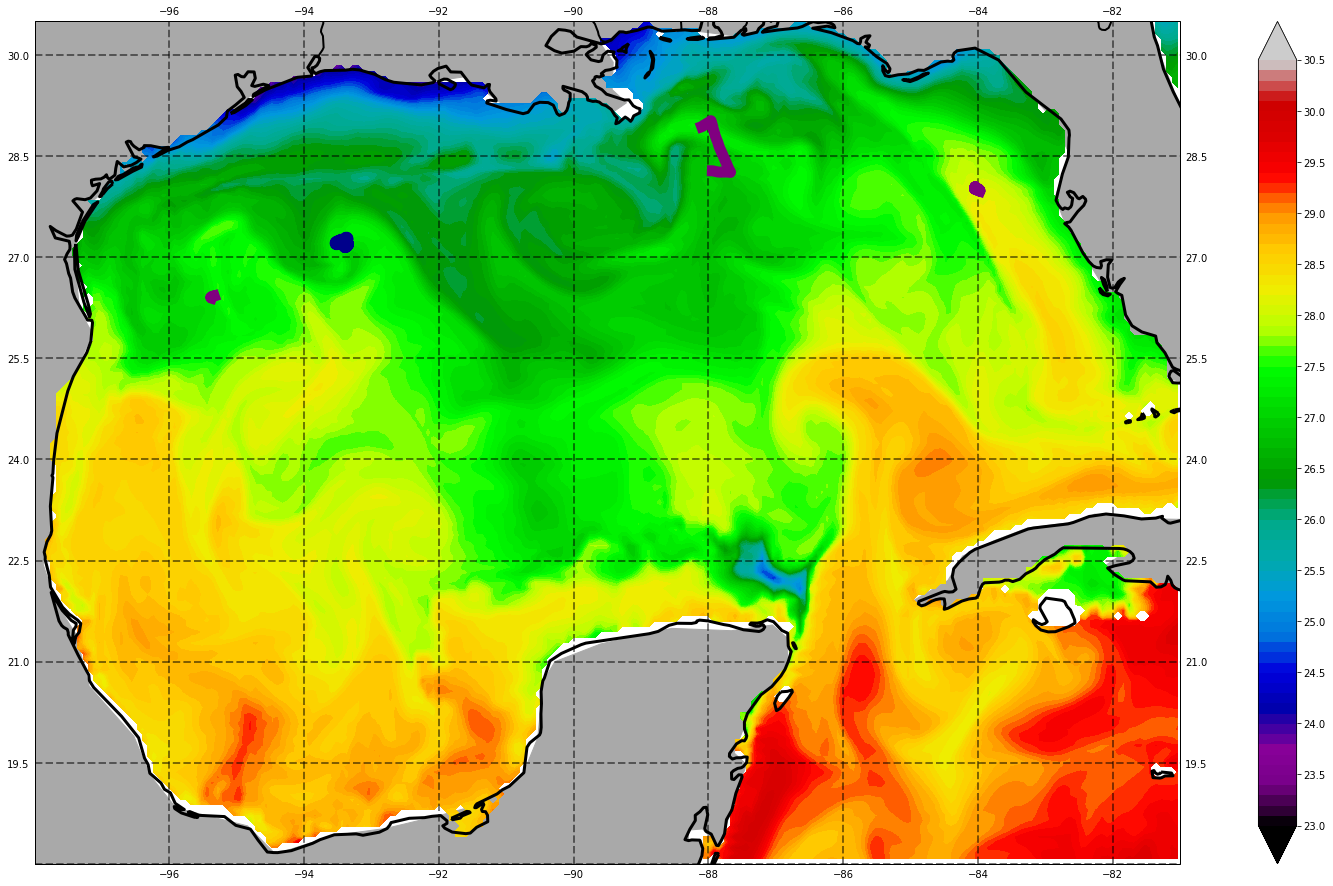

In [ ]:
#@title Main plotting code block... future goal is to make this transparent with layouts, colormaps, ranges, plotting parameters, etc., available via interactive widgets... currently, will print names of gliders, and then display map.  If you connect this to your Google drive, there is code that will allow you to save plots to the drive.
# Main plotting routine

# Plate Carree used... popular among flat-Earthers! ;)

# Feel free to go crazy... once the Jupyter Notebook is loaded, typing 
# "ccrs." should bring up your options for auto-complete, 
# including other projection options.
source_proj = ccrs.PlateCarree()

# nipy_spectral is a decent plot option to observe fronts over a wide
# range, though cmocean, Google turbo, and many others are more useful.
colorScale = 'nipy_spectral'
colorScaleWind = 'Greys'
cmap = mpl.cm.nipy_spectral

minPlotTemp, maxPlotTemp = 23, 30.5
tempRange = maxPlotTemp - minPlotTemp
mapPlotLevels = (int((tempRange) * 10 + 1))

minPlotWind, maxPlotWind = 10, 40
mapPlotLevelsWind = (int((maxPlotTemp-minPlotTemp) * 10 + 1))

dx, dy = 0, 0 # used to expand map coverage, less useful than planned
# lonMin, lonMax = lonMin - dx, lonMax + dx
# latMin, latMax = latMin - 0, latMax + dy

levels = np.linspace(minPlotTemp,maxPlotTemp,mapPlotLevels)
levelsWind = np.linspace(minPlotWind,maxPlotWind,mapPlotLevelsWind)

# animation is not called, but I may reintroduce the feature later
# the "animate" function is used, though
def animate():
  i = 0
  while i < 1:
    fig = plt.figure(figsize=(22, 12))
    ax = plt.axes(projection=source_proj)
    ax.set_xlim(lonMin-360,lonMax-360-0)
    ax.set_ylim(latMin,latMax)
    ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=-1);
    ax.coastlines(resolution='50m', color='black', linewidth=3);
    ax.background_patch.set_fill(False)
    ax.outline_patch.set_visible(True)

    # print('check resolution')
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none', linewidth=2);
    ax.add_feature(states_provinces, edgecolor='black');
    # print('...resolution okay')

    ax.background_patch.set_fill(False)
    i = 1

  for glider in sorted(g.groups, reverse=False):
    traj = dfG[dfG['trajectory'] == glider]
    print(traj['trajectory'][0])

    # okay, franklin was a bad glider... but otherwise this groups gliders
    # into Navy and non-Navy gliders, but could be used to group by NOAA,
    # Rutgers, CARICOOS, etc.

    if 'franklin-202007' not in traj['trajectory'][0]:
      im = ax.plot(traj['longitude'], traj['latitude'],
              linewidth=11, color='purple')#, label=glider)
    if 'ng' in traj['trajectory'][0]:
      im = ax.plot(traj['longitude'], traj['latitude'],
              linewidth=14, color='darkblue', zorder = 5)#, label=glider)

#    im2 = ax.contour(numLonsW, numLatsW, 
#                   latlonTempsW[i], levelsWind, 
#                   alpha=0.9, cmap=colorScaleWind, extend='both')
  im = ax.contourf(numLons, 
                   numLats, 
                   latlonTemps[0], 
                   levels, cmap=colorScale, extend='both')

  cbarTicks = np.linspace(minPlotTemp, maxPlotTemp, int(tempRange * 2 + 1))
  cbar = fig.colorbar(im, ax=ax, ticks=cbarTicks)

  fig.canvas.draw()
  fig.tight_layout()

#    ims.append(im)
#    Upon connecting your Google drive, you can set this up to stash hundreds 
#    of plots generated on-the-fly.
#    fig.savefig('drive/My Drive/Research/HURREX/unsorted plots/wind_' + 
#                timeInfo + '.png')

  gl = ax.gridlines(crs=source_proj, linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)

animate()

